In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime
import ModelsPlot as model_plot

#  宏观经济变量预测通货膨胀
# RF&GBDT

In [1]:
monthly_data = pd.read_csv('USA_Marco.csv',index_col=0)
monthly_data = monthly_data.loc[[x for x in monthly_data.index if x == x and '/'  in x]]
monthly_data.index = [pd.to_datetime(x) for x in monthly_data.index]
monthly_data['Dates'] = [int(x.strftime('%Y%m')) for x in monthly_data.index]

NameError: name 'pd' is not defined

In [3]:
merged = monthly_data
Ys_table = pd.read_csv('US_Marco_predictors.csv')
used_Ytable = Ys_table[['Dates','CPIAUCSLgrowth']]

merged = pd.merge(merged,used_Ytable,on = 'Dates')

st_month = 201001
ed_month = 201912
Xtodrop = ['Dates','y']##删掉预测值和不能用的指标
Xtodrop_add = [x for x in merged.columns if 'CPI' in x or 'cpi' in x]
Xtodrop = Xtodrop + Xtodrop_add


merged['y'] = merged['CPIAUCSLgrowth'].shift(-1)
whole_data = merged[(merged['Dates']>=st_month) & (merged['Dates']<=ed_month)].reset_index(drop = True)
whole_data = whole_data.fillna(0)

In [4]:
whole_data.drop(columns = Xtodrop).describe().T

,count,mean,std,min,25%,50%,75%,max
RPI,120.0,1.494266e+04,1230.616509,1.285230e+04,1.390553e+04,1.503529e+04,1.598108e+04,1.700896e+04
W875RX1,120.0,1.238146e+04,1076.180625,1.043750e+04,1.153440e+04,1.248280e+04,1.328825e+04,1.415250e+04
DPCERA3M086SBEA,120.0,1.073084e+02,7.984293,9.528700e+01,9.994650e+01,1.067425e+02,1.141165e+02,1.213850e+02
CMRMTSPLx,120.0,1.363940e+06,100433.398090,1.159614e+06,1.277268e+06,1.378559e+06,1.439420e+06,1.525606e+06
RETAILx,120.0,4.389027e+05,48641.933046,3.459590e+05,4.013280e+05,4.399220e+05,4.740600e+05,5.238620e+05
...,...,...,...,...,...,...,...,...
MZMSL,120.0,1.298053e+04,2202.160625,9.422600e+03,1.107620e+04,1.298770e+04,1.494400e+04,1.702050e+04
DTCOLNVHFNM,120.0,2.997012e+05,24310.262118,2.185536e+05,2.890769e+05,3.039856e+05,3.141505e+05,3.434730e+05
DTCTHFNM,120.0,7.816260e+05,66062.613964,6.421238e+05,7.282148e+05,7.739991e+05,8.377405e+05,8.968665e+05
INVEST,120.0,2.972592e+03,426.982520,2.294189e+03,2.631631e+03,2.945876e+03,3.367402e+03,3.824323e+03


In [8]:
def Norm(in_df,no_Norm):
    op_df = in_df.copy()
    for col in op_df.columns:
        if col in no_Norm:
            continue
        else:
            col_max = max(op_df[col])
            col_min = min(op_df[col])
            if col_max == col_min:
                continue
            op_df[col] = (op_df[col] - col_min) / (col_max - col_min)
    return op_df

In [9]:
all_month_list = list(whole_data['Dates'].values)
train_month_n = 24
test_month_n = 12
oos_month_n = 1

rf_op = []
gbdt_op = []

for i in range(len(all_month_list)):
    if i < train_month_n + test_month_n + oos_month_n - 1:
        continue
    else:
        
        train_monthes = all_month_list[i-test_month_n-train_month_n:i-test_month_n]
        test_monthes = all_month_list[i-test_month_n:i]
        oos_month = all_month_list[i]
        print(oos_month)
        
        train_data = whole_data[whole_data['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data = whole_data[whole_data['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data = whole_data[whole_data['Dates'] == oos_month]
        

        
        X_train = train_data.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test = test_data.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos = oos_data.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        to_Norm = pd.concat([train_data,test_data,oos_data])
        normed_data = Norm(to_Norm,Xtodrop)
        train_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in train_monthes else False)]
        test_data_normed = normed_data[normed_data['Dates'].apply(lambda x: True if x in test_monthes else False)]
        oos_data_normed = normed_data[normed_data['Dates'] == oos_month]
        
        X_train_normed = train_data_normed.drop(columns = Xtodrop)
        y_train = train_data['y']
        
        X_test_normed = test_data_normed.drop(columns = Xtodrop)
        y_test = test_data['y']
        
        X_oos_normed = oos_data_normed.drop(columns = Xtodrop)
        y_oos = oos_data['y']
        
        rf_result = model_plot.RandomForest_method(X_train,y_train,X_test,y_test,X_oos, test_data, oos_data)
        gbdt_result = model_plot.GBDT_method(X_train,y_train,X_test,y_test,X_oos, test_data, oos_data)
        
        rf_op.append(rf_result)
        gbdt_op.append(gbdt_result)
        

201301
201302
201303
201304


201305
201306
201307


201308
201309
201310


201311
201312


201401
201402
201403


201404
201405
201406


201407
201408
201409


201410
201411


201412
201501
201502


201503
201504
201505


201506
201507
201508


201509
201510


201511
201512
201601


201602
201603
201604


201605
201606
201607


201608
201609


201610
201611
201612


201701
201702
201703


201704
201705
201706


201707
201708


201709
201710
201711


201712
201801
201802


201803
201804
201805


201806
201807


201808
201809
201810


201811
201812
201901


201902
201903
201904


201905
201906


201907
201908
201909


201910
201911
201912


# randomforest

MSFE:  7.8273526628324e-06
R2: (n = 2) -0.44499534890207926


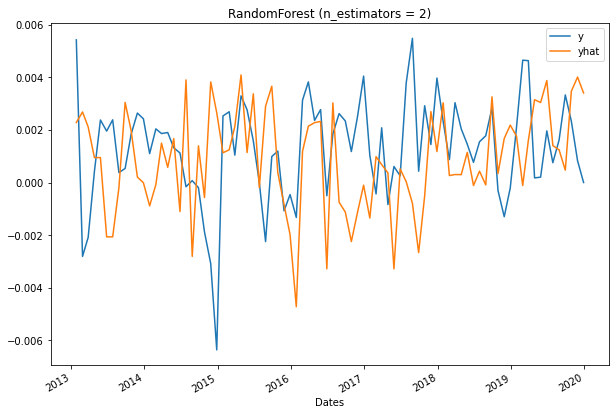

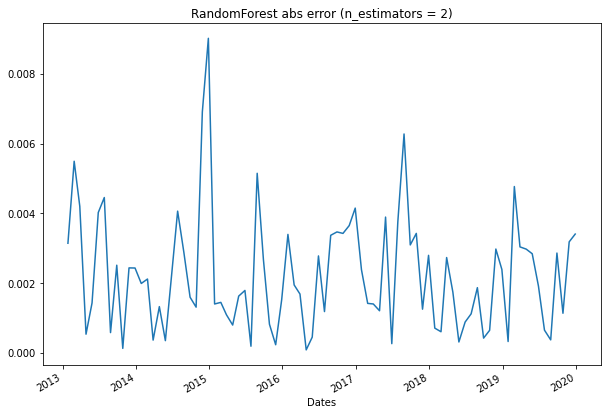

MSFE:  7.665564513049436e-06
R2: (n = 3) -0.41512789128081296


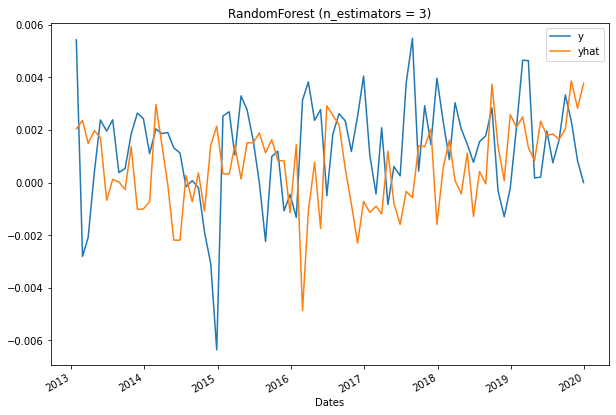

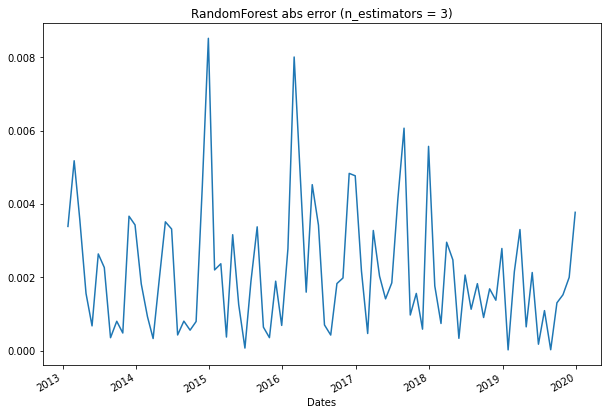

MSFE:  5.700951622087398e-06
R2: (n = 4) -0.052443774170143787


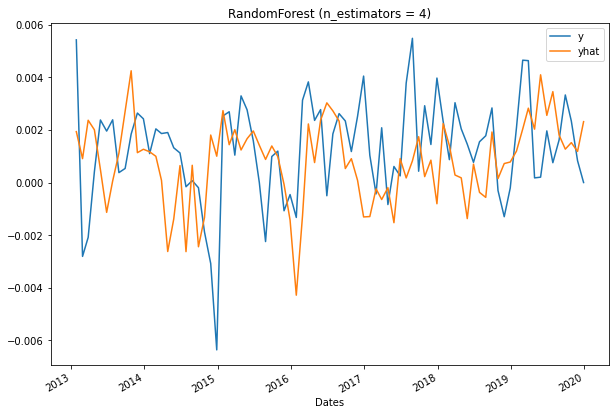

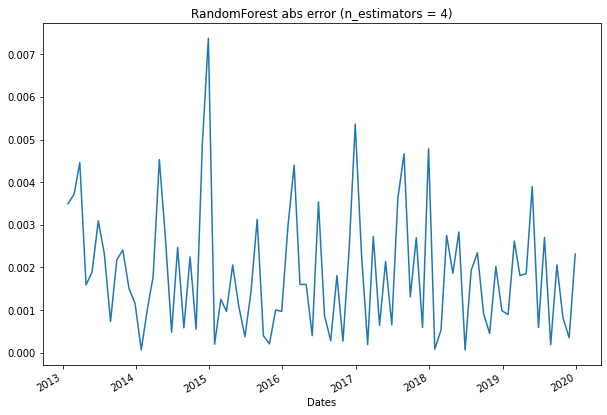

MSFE:  5.7476918898489665e-06
R2: (n = 5) -0.061072421994153414


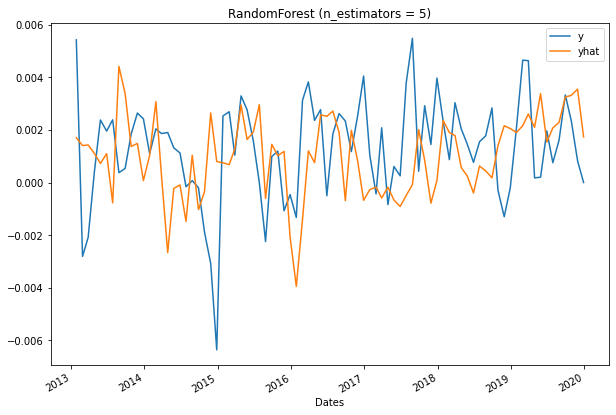

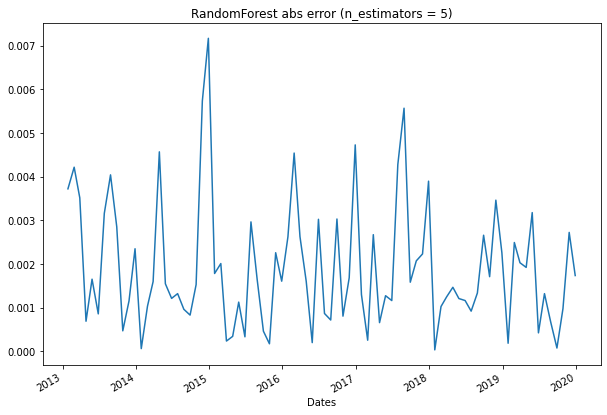

MSFE:  6.546399752536249e-06
R2: (n = 6) -0.20852063295760437


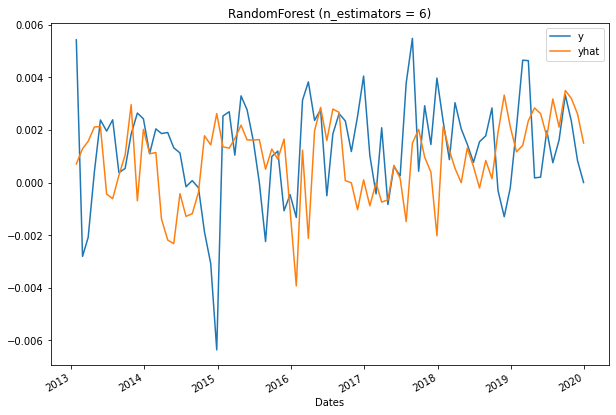

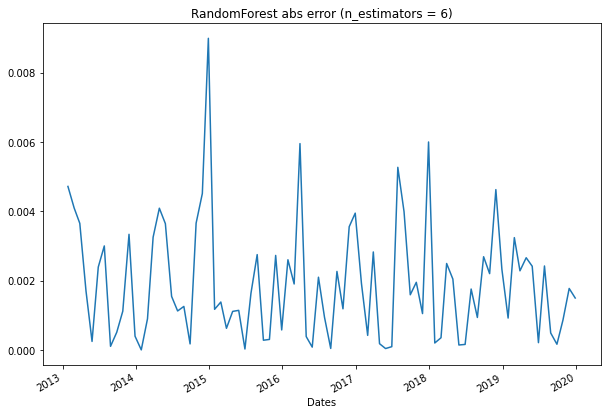

In [32]:
# deal with randomforest
all_pred = []
all_best = []
all_coef = []
for i in range(len(all_month_list)):
    if i < train_month_n + test_month_n + oos_month_n - 1:
        continue
    else:
        result_idx = i - (train_month_n + test_month_n + oos_month_n - 1)
        oos_month = all_month_list[i]
        
        temp_tuning = rf_op[result_idx][0]
        temp_best = rf_op[result_idx][1]
        temp_coef = rf_op[result_idx][2]
        
        all_best.append(temp_best)
        
        temp_coef = pd.DataFrame(temp_coef).T
        temp_coef['AlphaValue'] = temp_coef.index
        temp_coef['Dates'] = oos_month
        all_coef.append(temp_coef)
        all_pred.append(temp_tuning)
        
        
all_pred = pd.concat(all_pred)
all_pred['Dates'] = [datetime.datetime(year = int(x//100),month = int(x%100),day = 28) for x in all_pred['Dates']]
all_pred = all_pred.sort_values(['n_estimators','Dates'])
all_pred = all_pred.set_index(['n_estimators','Dates'])

n_es = [2,3,4,5,6] 
for n in n_es:
    
    alpha_pred = all_pred.loc[n]
    msfe = np.sum((alpha_pred['yhat']-alpha_pred['y'])**2) / len(alpha_pred)
    print('MSFE: ', msfe)
    r2 = 1-np.sum((alpha_pred['yhat']-alpha_pred['y'])**2)/np.sum(alpha_pred['y']**2)
    print('R2: (n = %s)'%n, r2)
    
    alpha_pred[['y','yhat']].plot(figsize = (10,7),title = 'RandomForest (n_estimators = %s)'%n)
    plt.show()
    
    abs(alpha_pred['y']- alpha_pred['yhat']).plot(figsize = (10,7),title = 'RandomForest abs error (n_estimators = %s)'%n)
    plt.show()  


# gbdt

MSFE:  4.25540784615481e-06
R2: (n = 2) 0.21441580439151586


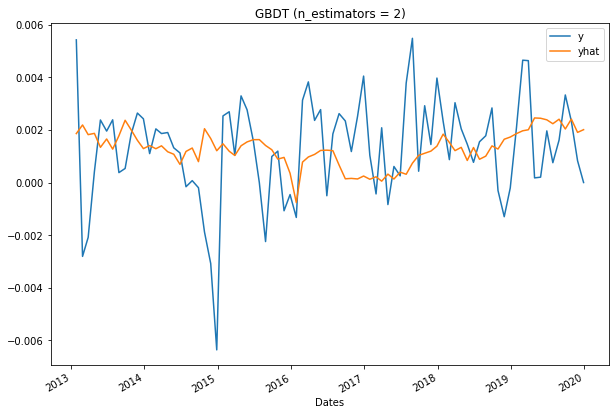

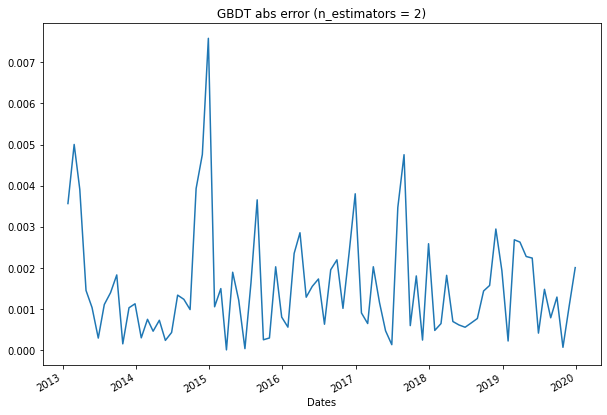

MSFE:  4.232942213846286e-06
R2: (n = 3) 0.21856314968108081


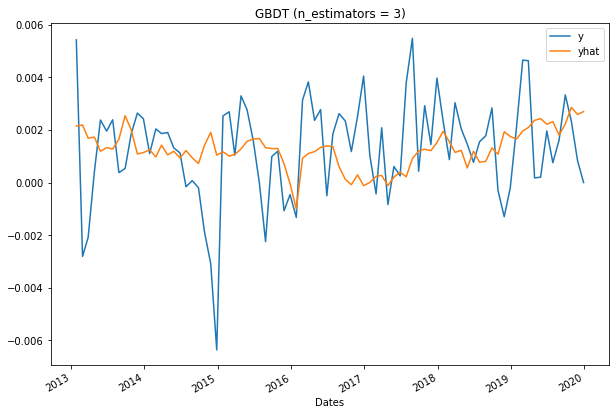

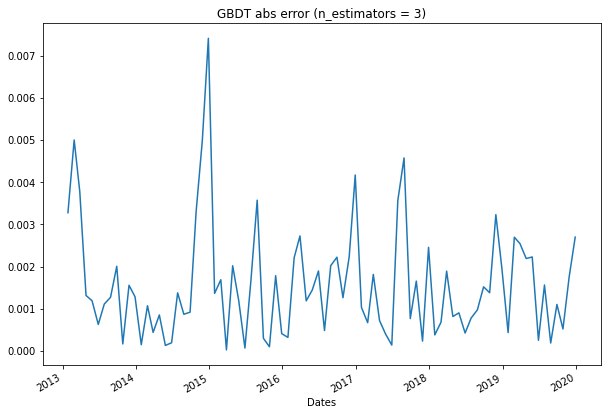

MSFE:  4.322124872279385e-06
R2: (n = 4) 0.2020992784094474


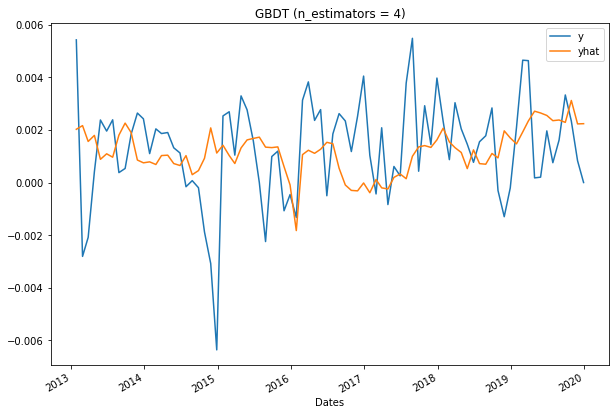

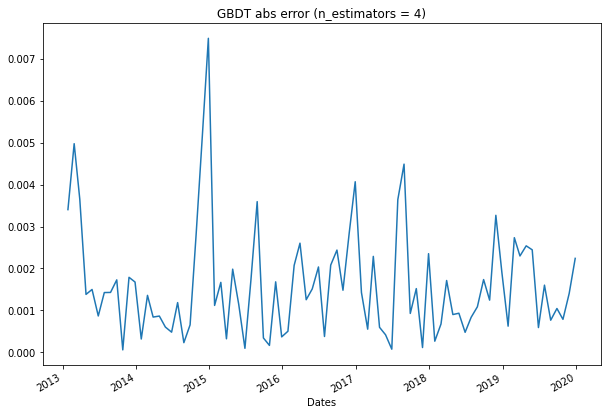

MSFE:  4.407284283917166e-06
R2: (n = 5) 0.18637813244445856


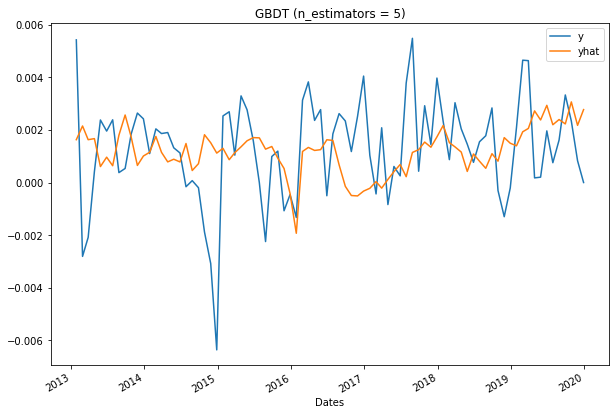

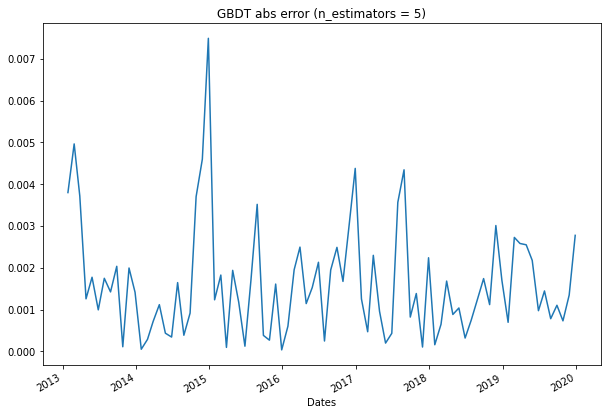

MSFE:  4.590519433487708e-06
R2: (n = 6) 0.15255137769223326


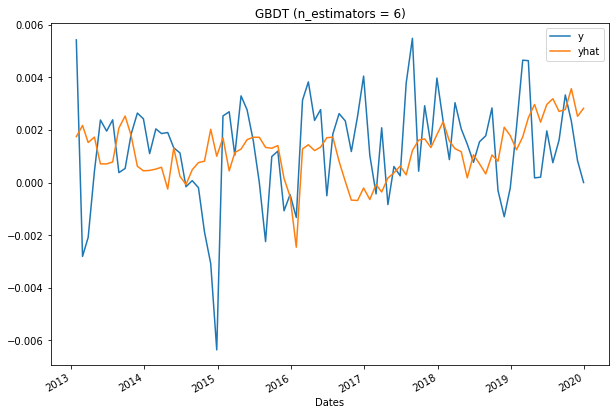

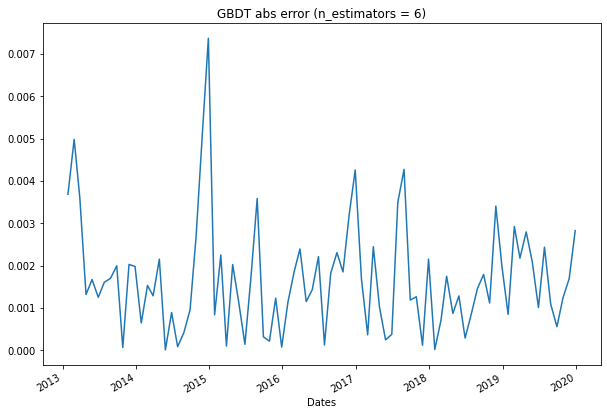

In [31]:
# deal with gbdt
all_pred = []
all_best = []
all_coef = []
for i in range(len(all_month_list)):
    if i < train_month_n + test_month_n + oos_month_n - 1:
        continue
    else:
        result_idx = i - (train_month_n + test_month_n + oos_month_n - 1)
        oos_month = all_month_list[i]
        
        temp_tuning = gbdt_op[result_idx][0]
        temp_best = gbdt_op[result_idx][1]
        temp_coef = gbdt_op[result_idx][2]
        
        all_best.append(temp_best)
        
        temp_coef = pd.DataFrame(temp_coef).T
        temp_coef['AlphaValue'] = temp_coef.index
        temp_coef['Dates'] = oos_month
        all_coef.append(temp_coef)
        all_pred.append(temp_tuning)
        
        
all_pred = pd.concat(all_pred)
all_pred['Dates'] = [datetime.datetime(year = int(x//100),month = int(x%100),day = 28) for x in all_pred['Dates']]
all_pred = all_pred.sort_values(['n_estimators','Dates'])
all_pred = all_pred.set_index(['n_estimators','Dates'])

n_es = [2,3,4,5,6] 
for n in n_es:
    
    alpha_pred = all_pred.loc[n]
    msfe = np.sum((alpha_pred['yhat']-alpha_pred['y'])**2) / len(alpha_pred)
    print('MSFE: ', msfe)
    r2 = 1-np.sum((alpha_pred['yhat']-alpha_pred['y'])**2)/np.sum(alpha_pred['y']**2)
    print('R2: (n = %s)'%n, r2)
    
    alpha_pred[['y','yhat']].plot(figsize = (10,7),title = 'GBDT (n_estimators = %s)'%n)
    plt.show()
    
    abs(alpha_pred['y']- alpha_pred['yhat']).plot(figsize = (10,7),title = 'GBDT abs error (n_estimators = %s)'%n)
    plt.show()  
